In [34]:
import warnings

warnings.filterwarnings('ignore')

import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path

path = os.path.realpath(os.path.join('..', '..'))
os.chdir(path)

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from src.preprocessing.preprocessing import Preprocessing
from src.tools.config import Config

## 1 Config

In [2]:
seed = 87076143
np.random.seed(seed)

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

cpu_threads = Config.hardware.n_cpu
has_cuda = torch.cuda.is_available()
train_mode = True
test_mode = True

pp = Preprocessing()

**To accelerate RandomForestClassifier & ExtraTreesClassifier execute this in a terminal:**

In [3]:
# Of course without the '#' and cpu_threads the number of threads you want to use
# export OPENBLAS_NUM_THREADS=cpu_threads
# export GOTO_NUM_THREADS=cpu_threads
# export OMP_NUM_THREADS=cpu_threads

### 1.1 Setup helper Functions

In [4]:
def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(25, 20))
    _ = sns.heatmap(
        corr,
        #square=True, 
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )

## 2.2 Load Data

In [5]:
data_folder = Path(Config.path.data_folder)
train_file = data_folder / "features_train_i.csv"
test_file = data_folder / "features_test_i.csv"
train = pd.read_csv(str(train_file))
test = pd.read_csv(str(test_file))

## 2.3 Data overview

In [8]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,1.122646,1.333742,4.064393,1.519819,0.446206,0.424013,2.321279,0.476424,0.812524,1.659822,0.433983,0.605229,0.112734,0.463859,1.0
1,1.434266,1.363666,2.314129,1.943999,0.866211,0.424013,2.645380,2.610151,0.500365,3.016007,1.636214,0.605229,4.374885,0.463859,0.0
2,2.396700,2.235687,2.593910,0.975416,0.869074,0.020682,2.993066,2.077382,1.318195,3.310964,1.450780,0.249506,2.493100,2.733438,0.0
3,2.407352,1.728553,3.409448,2.167990,0.779269,0.300677,5.197195,0.309889,0.890287,2.269082,0.537086,0.536786,1.242502,0.470712,1.0
4,1.062646,1.372674,3.550878,2.092583,1.554236,0.971095,2.042542,1.798505,1.344919,1.918058,0.381050,0.843711,1.939142,0.396581,1.0


In [9]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
count,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000,196526.000000
mean,1.225939,0.962938,2.826252,1.562816,0.823232,0.666422,2.701471,2.793522,0.993222,2.400832,0.870907,0.791543,2.702771,1.171241,0.500000
std,0.870911,0.897603,1.301374,0.745267,0.359468,0.357246,1.189679,1.813804,0.996560,0.945673,0.534602,0.531769,2.207784,0.772058,0.500001
min,-2.347282,-2.213404,-0.887716,-1.947555,-0.280180,-2.115055,-0.447965,-1.392575,-1.162015,-1.129003,-2.730874,-1.868317,-0.578030,-1.476681,0.000000
25%,0.685419,0.419191,1.997383,0.817105,0.660836,0.430129,1.928992,1.631034,0.505430,1.809445,0.511211,0.587905,1.047637,0.617065,0.000000
50%,1.214966,1.019930,2.621802,1.904964,0.796528,0.633883,2.643751,2.459398,0.723138,2.228544,0.744143,0.697809,2.185762,0.968300,0.500000
75%,1.776718,1.566869,3.369881,2.196859,0.971354,0.865491,3.423146,3.718671,1.054868,2.908694,1.096946,0.828235,3.545369,1.578456,1.000000
max,5.277227,4.872844,8.465793,4.665638,6.272193,6.362071,9.926394,16.488726,11.719955,6.674792,8.066112,9.129678,16.945679,7.830724,1.000000


### 2.4 Heat map of feature correlation
**This might be interesting although we don't know anything about the purpose of the indivual features:**

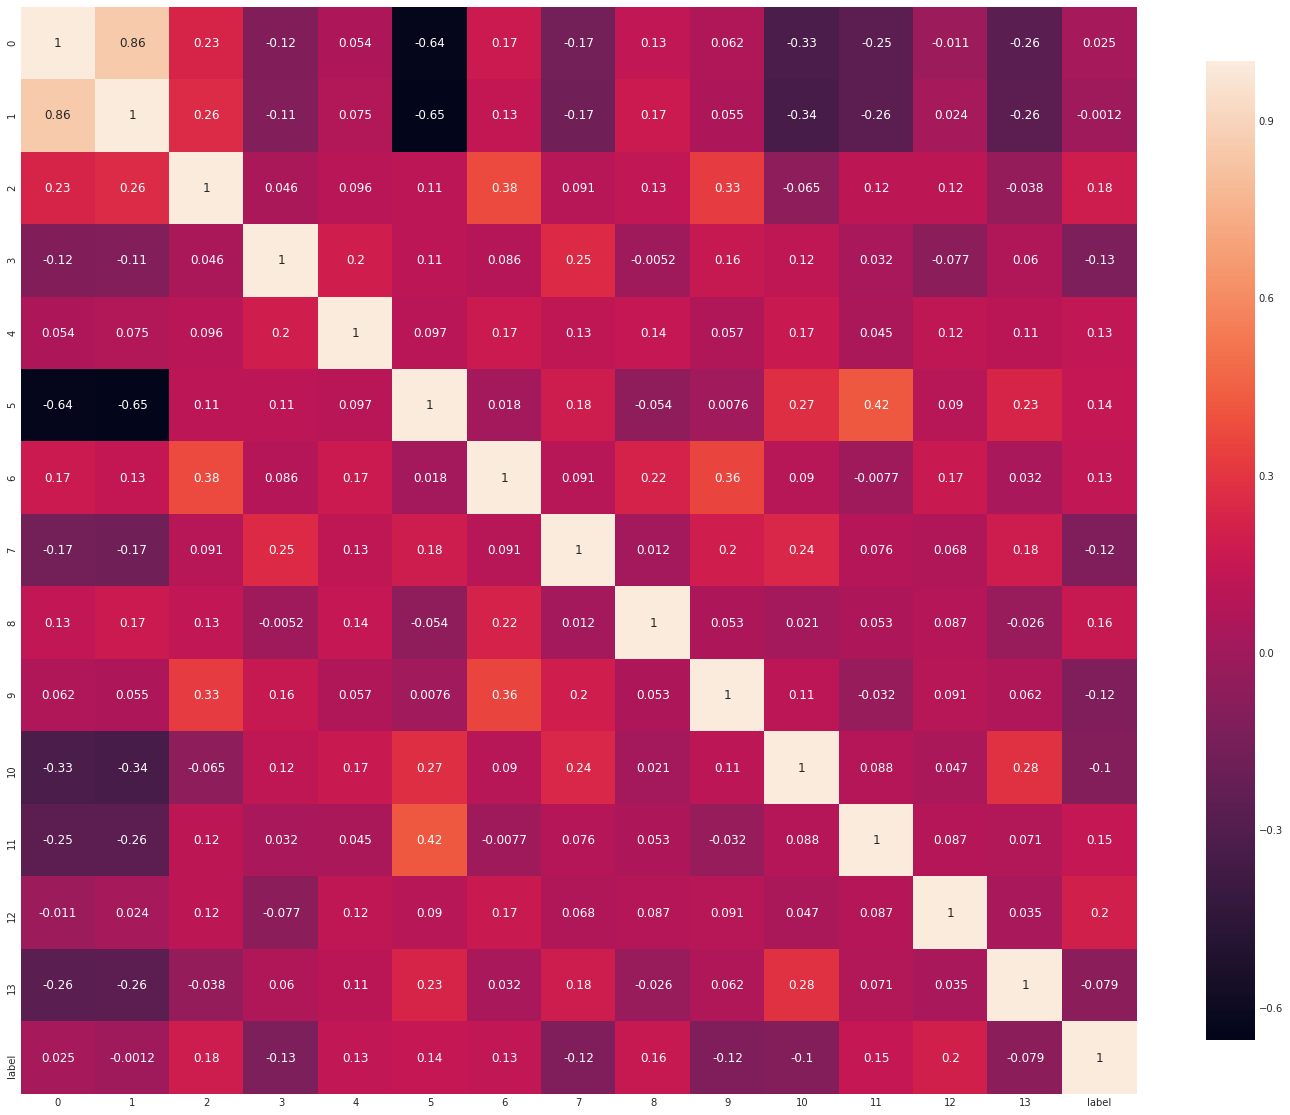

In [10]:
plot_correlation_map(train)

# 3. Data Preparation

## 3.1 Normalization & Label

In [11]:
# This has the disadvantage, that the whole train-set is normalized 
# and not the individual folds for k-fold CV.
# Which leads to some overfitting because the distribution was calculated with regard to the whole set
train_norm = train.copy(deep=True)
test_norm = test.copy(deep=True)
train_label = train_norm['label']
test_label = test_norm['label']
train_norm.drop(['label'], axis=1, inplace=True)
test_norm.drop(['label'], axis=1, inplace=True)
train_norm = pp.normalize_np_array(train_norm.values)
test_norm = pp.normalize_np_array(test_norm.values)

In [12]:
header = train.columns.values.tolist()
header = header[0:-1]
train_norm = pd.DataFrame(data=train_norm, columns=header)
test_norm = pd.DataFrame(data=test_norm, columns=header)

## 3.2 K-fold Cross Validation

In [13]:
# This will retain the same percentage of the classes in the folds
skf_cv_iter = StratifiedKFold(n_splits=9, shuffle=True, random_state=seed)

# 4. Grid Search - Parameter Definition

## 4.1 CatBoost

In [14]:
# params_grid_cb = {
#     'max_depth': [4],
#     'n_estimators': np.linspace(16, 50, 18, dtype=np.int),
#     'learning_rate': np.concatenate([np.linspace(0.01, 0.07, 7)
#                                      , np.linspace(0.1, 0.9, 17)]),
# #      'subsample': np.linspace(0.7, 1.0, 7),
# #      'colsample_bytree': np.linspace(0.55, 0.85, 7)
# }
# params_grid_cb = {
#     'max_depth': [4],
#     'n_estimators': [26],
#     'learning_rate': [0.25],
#     'subsample': [0.8],
#     'colsample_bytree': [0.7]
# }


In [15]:
# params_fixed_cb = {
#     'objective': 'binary:logistic',
#     'silent': 1,
#     'missing': -1,
#     'seed': seed,
#     'nthread': cpu_threads
# }


## 4.2 Random Forest

In [16]:
max_feature_count = len(train_norm.columns.values)
max_features = [int(round(np.sqrt(max_feature_count)))
    , int(round(np.log2(max_feature_count)))
    , max_feature_count // 2
    , int(round(max_feature_count * 3 / 4))
    , max_feature_count]
max_features = list(set(max_features))
params_grid_rf = {
    'max_depth': [3, 5, 8, max_feature_count],
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_features': max_features,
    'bootstrap': [True],
    'oob_score': [True]
}
# params_grid_et = {
#     'max_depth': [14],
#     'n_estimators': [100],
#     'max_features': [4],
#     'bootstrap': [True],
#     'oob_score': [True]
# }

In [17]:
params_fixed_rf = {
    'verbose': 0,
    'random_state': seed,
    'n_jobs': cpu_threads
}

## 4.3 Extremely Randomized Trees

In [18]:
params_grid_et = {
    'max_depth': [3, 5, 8, max_feature_count],
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_features': max_features,
    'bootstrap': [True],
    'oob_score': [True]
}
# params_grid_et = {
#     'max_depth': [14],
#     'n_estimators': [100],
#     'max_features': [14],
#     'bootstrap': [True],
#     'oob_score': [True]
# }

In [19]:
params_fixed_et = {
    'verbose': 0,
    'random_state': seed,
    'n_jobs': cpu_threads
}

## 4.4 Logistic Regression

In [20]:
regularisation_list_lr = [0.001, 0.01, 0.1, 1, 10, 100]
params_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': regularisation_list_lr,
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear'],
}
# params_grid_lr = {
#     'penalty': ['l2'],
#     'C': [0.01],
#     'class_weight': [None],
#     'solver': ['liblinear']
# }

In [21]:
params_fixed_lr = {
    'verbose': 0,
    'random_state': seed,
    'n_jobs': cpu_threads
}

# 5. Training

## 5.1 Model selection

### 5.1.1 CatBoost

In [22]:
# Because it is with standard values alreads very good, so we won't use GridSearch

### 5.1.2 Random Forest

In [23]:
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(**params_fixed_rf),
    param_grid=params_grid_rf,
    cv=skf_cv_iter,
    n_jobs=cpu_threads,
    scoring='accuracy',
    iid=True
)

### 5.1.3 Extremely Randomized Trees

In [24]:
et_grid = GridSearchCV(
    estimator=ExtraTreesClassifier(**params_fixed_et),
    param_grid=params_grid_et,
    cv=skf_cv_iter,
    n_jobs=cpu_threads,
    scoring='accuracy',
    iid=True
)

### 5.1.4 Logistic Regression

In [25]:
lr_grid = GridSearchCV(
    estimator=LogisticRegression(**params_fixed_lr),
    param_grid=params_grid_lr,
    cv=skf_cv_iter,
    n_jobs=cpu_threads,
    scoring='accuracy',
    iid=True
)

## 5.2 Train the models

In [26]:
%%time
rf_grid.fit(train_norm, train_label)

CPU times: user 1min 42s, sys: 1.01 s, total: 1min 43s
Wall time: 1h 15min 29s


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=87076143, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
            oob_score=False, random_state=87076143, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_features': [10, 4, 14, 7], 'max_depth': [3, 5, 8, 14], 'bootstrap': [True], 'n_estimators': [5, 10, 25, 50, 75, 100], 'oob_score': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
%%time
et_grid.fit(train_norm, train_label)

CPU times: user 46.6 s, sys: 468 ms, total: 47.1 s
Wall time: 12min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=87076143, shuffle=True),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
           oob_score=False, random_state=87076143, verbose=0,
           warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_features': [10, 4, 14, 7], 'max_depth': [3, 5, 8, 14], 'bootstrap': [True], 'n_estimators': [5, 10, 25, 50, 75, 100], 'oob_score': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [28]:
%%time
lr_grid.fit(train_norm, train_label)

CPU times: user 5.9 s, sys: 124 ms, total: 6.02 s
Wall time: 42 s


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=87076143, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=6,
          penalty='l2', random_state=87076143, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

%%time
et_grid.fit(train_norm, train_label)

# 6. Evaluation

## 6.1 Model performance

In [29]:
print("=== Random Forest ===")
print("Best accuracy obtained: {0}".format(rf_grid.best_score_))
print("Parameters:")
for key, value in rf_grid.best_params_.items():
    print("\t{}: {}".format(key, value))
model_rf = rf_grid.best_estimator_

=== Random Forest ===
Best accuracy obtained: 0.689135279810305
Parameters:
	max_features: 4
	max_depth: 14
	bootstrap: True
	n_estimators: 100
	oob_score: True


In [30]:
print("=== Extremely Randomized Trees ===")
print("Best accuracy obtained: {0}".format(et_grid.best_score_))
print("Parameters:")
for key, value in et_grid.best_params_.items():
    print("\t{}: {}".format(key, value))
model_et = et_grid.best_estimator_

=== Extremely Randomized Trees ===
Best accuracy obtained: 0.6865147614056155
Parameters:
	max_features: 14
	max_depth: 14
	bootstrap: True
	n_estimators: 100
	oob_score: True


In [31]:
print("=== Logistic Regression ===")
print("Best accuracy obtained: {0}".format(lr_grid.best_score_))
print("Parameters:")
for key, value in lr_grid.best_params_.items():
    print("\t{}: {}".format(key, value))
model_lr = lr_grid.best_estimator_

=== Logistic Regression ===
Best accuracy obtained: 0.6938318593977387
Parameters:
	penalty: l2
	solver: liblinear
	class_weight: None
	C: 0.01


## 6.2 Model comparison

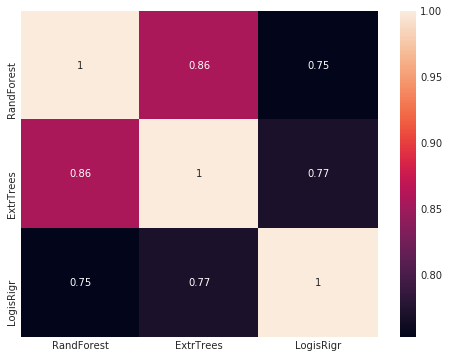

In [32]:
train_survived_rf = pd.Series(model_rf.predict(train_norm), name="RandForest")
train_survived_et = pd.Series(model_et.predict(train_norm), name="ExtrTrees")
train_survived_lr = pd.Series(model_lr.predict(train_norm), name="LogisRigr")

# Concatenate all classifier results
ensemble_results = pd.concat([train_survived_rf, train_survived_et, train_survived_lr], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

# 7. Ensemble Modeling

In [37]:
estimators = [('lr', model_lr), ('rf', model_rf), ('et', model_et)]
ensemble_cl = VotingClassifier(estimators=estimators, voting='soft', n_jobs=cpu_threads)
ensemble_cl = ensemble_cl.fit(train_norm, train_label)

# 8. Test

 
## 7.1 Individual Models

In [39]:
if test_mode:
    pred_rf = model_rf.predict(test_norm)
    score_rf = np.mean(pred_rf == test_label)
    print("Random Forest: {:3.1f}".format(score_rf * 100))

    pred_et = model_et.predict(test_norm)
    score_et = np.mean(pred_et == test_label)
    print("Extra Trees: {:3.1f}".format(score_et * 100))

    pred_lr = model_lr.predict(test_norm)
    score_lr = np.mean(pred_lr == test_label)
    print("Logistic Regession: {:3.1f}".format(score_lr * 100))

Random Forest: 68.8
Extra Trees: 68.8
Logistic Regession: 68.8


## 7.2 Ensemble

In [40]:
if test_mode:
    pred_en = ensemble_cl.predict(test_norm)
    score_en = np.mean(pred_en == test_label)
    print("Logistic Regession: {:3.1f}".format(score_en * 100))

Logistic Regession: 69.1
